# Try WEAT on Multiple Embeddings (some debiased)

In [1]:
%load_ext autoreload
%autoreload 2

In [177]:
from gensim.models import KeyedVectors

from WEAT.WEAT import WEAT
import random
random.seed(42)

## Import a bunch of diff embeddings

Some are debiased

In [3]:
GLOVE_EMBED_PATH     = '../random/dnd_text_gen/glove/glove.6B.300d.w2vformat.txt'
DEB_GLOVE_EMBED_PATH = '../random/dnd_text_gen/glove/glove.6B.300d_debiased.txt'  # also w2vformat
NBB_EMBED_PATH       = 'data/numberbatch-en-17.06.txt'  # also w2vformat
BOL_EMBED_PATH       = 'data/GoogleNews-vectors-negative300-hard-debiased.bin.gz'

In [4]:
deb_model = KeyedVectors.load_word2vec_format(DEB_GLOVE_EMBED_PATH)
#deb_model.init_sims(replace=True)

In [5]:
model = KeyedVectors.load_word2vec_format(GLOVE_EMBED_PATH)
#model.init_sims(replace=True)

In [6]:
nbb_model = KeyedVectors.load_word2vec_format(NBB_EMBED_PATH)
#nbb_model.init_sims(replace=True)

In [7]:
bol_model = KeyedVectors.load_word2vec_format(BOL_EMBED_PATH, binary=True)
#bol_model.init_sims(replace=True)

### Make WEAT testing objects

In [158]:
weat = WEAT(model)
deb_weat = WEAT(deb_model)
nbb_weat = WEAT(nbb_model)
bol_weat = WEAT(bol_model)

### Run a Science & Art vs Gender test

In [10]:
science_v_art = []

X_science = set('science, technology, physics, chemistry, Einstein, NASA, experiment, astronomy'.lower().split(', '))
Y_arts = set('poetry, art, Shakespeare, dance, literature, novel, symphony, drama'.lower().split(', '))
attr_male = 'male, man, boy, brother, he, him, his, son'.split(', ')
attr_female = 'female, woman, girl, sister, she, her, hers, daughter'.split(', ')


# FIXME rename method to .custom_test()
# FIXME get rid of printing partitions unless showing other warnings
# FIXME doc strings
# FIXME add the vocab as a static attribute so we can load embeddings way faster
e, p = weat.perform_test(X_science, Y_arts, attr_male, attr_female)
science_v_art.append({'effect_size':e, 'p_val':p, 'embedding':'GloVe'})

e, p = deb_weat.perform_test(X_science, Y_arts, attr_male, attr_female)
science_v_art.append({'effect_size':e, 'p_val':p, 'embedding':'deb_GloVe'})

e, p = nbb_weat.perform_test(X_science, Y_arts, attr_male, attr_female)
science_v_art.append({'effect_size':e, 'p_val':p, 'embedding':'numberbatch'})

e, p = bol_weat.perform_test(X_science, Y_arts, attr_male, attr_female)
science_v_art.append({'effect_size':e, 'p_val':p, 'embedding':'deb_GNews'})

### For plotting

In [17]:
%matplotlib inline

from WEAT.utils import plot_test
import pandas as pd

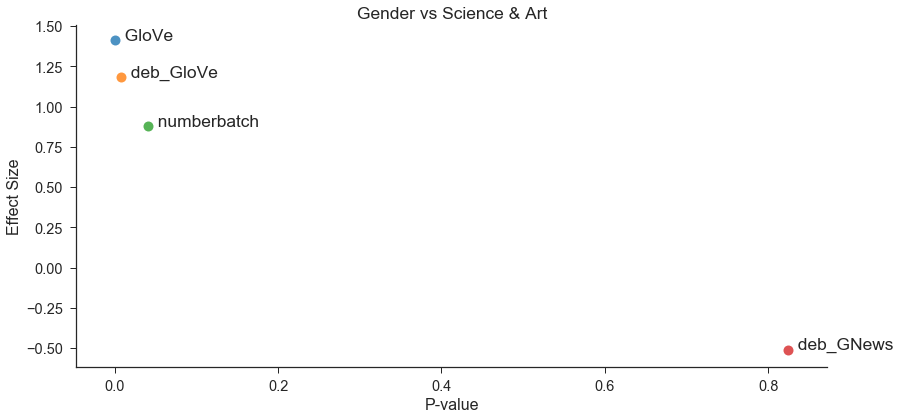

In [19]:
sci_v_art = pd.DataFrame(science_v_art)
plot_test(sci_v_art, 'Gender vs Science & Art')

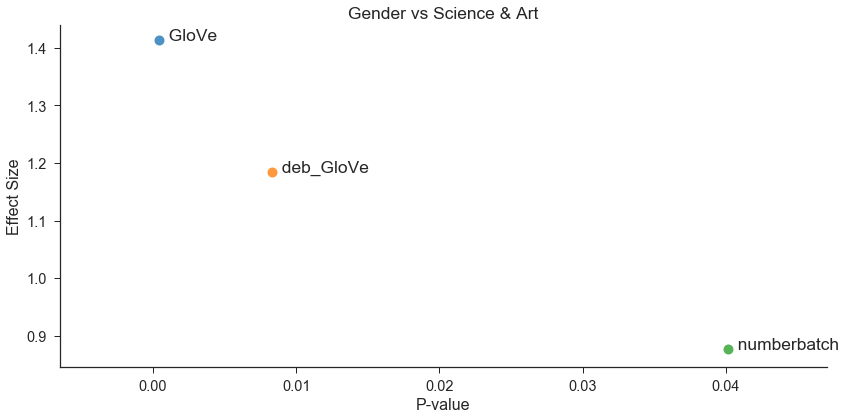

In [20]:
plot_test(sci_v_art[sci_v_art.p_val <= 0.05], 'Gender vs Science & Art')

### Try Racial Bias test

In [169]:
eu_amer_names = """Adam, Chip, Harry, Josh, Roger, Alan, Frank,
 Ian, Justin, Ryan, Andrew, Fred, Jack, Matthew, Stephen, Brad,
 Greg, Jed, Paul, Todd, Brandon, Hank, Jonathan, Peter, Wilbur,
 Amanda, Courtney, Heather, Melanie, Sara, Amber, Crystal,
 Katie, Meredith, Shannon, Betsy, Donna, Kristin, Nancy, Stephanie,
 Bobbie-Sue, Ellen, Lauren, Peggy, Sue-Ellen, Colleen, Emily,
 Megan, Rachel, Wendy""".replace('\n','').lower().split(', ')

af_amer_names = """Alonzo, Jamel, Lerone, Percell, Theo, Alphonse,
 Jerome, Leroy, Rasaan, Torrance, Darnell, Lamar, Lionel, Rashaun,
 Tvree, Deion, Lamont, Malik, Terrence, Tyrone, Everol, Lavon,
 Marcellus, Terryl, Wardell, Aiesha, Lashelle, Nichelle, Shereen,
 Temeka, Ebony, Latisha, Shaniqua, Tameisha, Teretha, Jasmine,
 Latonya, Shanise, Tanisha, Tia, Lakisha, Latoya, Sharise, Tashika,
 Yolanda, Lashandra, Malika, Shavonn, Tawanda,
 Yvette""".replace('\n','').lower().split(', ')

oov_glove = {'bobbie-sue', 'sue-ellen', 'aiesha', 'tashika',
             'tameisha', 'shavonn', 'lashelle', 'lashandra',
             'rasaan', 'shanise', 'percell', 'teretha',
             'sharise', 'tvree', 'everol'}
oov_nbb = {'bobbie-sue', 'sue-ellen', 'lerone', 'lakisha',
           'aiesha', 'latisha', 'tashika', 'tameisha',
           'shavonn', 'temeka', 'tawanda', 'lashelle',
           'lashandra', 'rashaun', 'rasaan', 'shanise',
           'terryl', 'teretha', 'shereen', 'sharise',
           'tvree', 'everol'}
oov_bol = {'bobbie-sue', 'wilbur', 'jed', 'sue-ellen',
           'yvette', 'latonya', 'lashandra', 'rashaun',
           'shanise', 'teretha', 'nichelle', 'marcellus',
           'tvree', 'jamel', 'tyrone', 'tanisha', 'shavonn',
           'tawanda', 'rasaan', 'sharise', 'wardell',
           'lerone', 'aiesha', 'tashika', 'darnell',
           'yolanda', 'deion', 'lashelle', 'terryl',
           'percell', 'lamont', 'latoya', 'lakisha',
           'everol', 'latisha', 'tameisha', 'lavon',
           'malika', 'shaniqua', 'terrence', 'alphonse',
           'alonzo', 'temeka', 'torrance', 'shereen'}
len(oov_bol)

45

#### Pick a subset of names common to all embeddings

This smaller subset will also eliminate the need to sample from the complete set of partitions and allow us to calculate more accurate p-values.

In [175]:
g_eu = set(eu_amer_names).difference(oov_glove)
n_eu = set(eu_amer_names).difference(oov_nbb)
b_eu = set(eu_amer_names).difference(oov_bol)
shared_eu_amer_names = g_eu.intersection(n_eu).intersection(b_eu)

g_afr = set(af_amer_names).difference(oov_glove)
n_afr = set(af_amer_names).difference(oov_nbb)
b_afr = set(af_amer_names).difference(oov_bol)
shared_afr_amer_names = g_afr.intersection(n_afr).intersection(b_afr)

shared_eu_amer_names, shared_afr_amer_names

({'adam',
  'alan',
  'amanda',
  'amber',
  'andrew',
  'betsy',
  'brad',
  'brandon',
  'chip',
  'colleen',
  'courtney',
  'crystal',
  'donna',
  'ellen',
  'emily',
  'frank',
  'fred',
  'greg',
  'hank',
  'harry',
  'heather',
  'ian',
  'jack',
  'jonathan',
  'josh',
  'justin',
  'katie',
  'kristin',
  'lauren',
  'matthew',
  'megan',
  'melanie',
  'meredith',
  'nancy',
  'paul',
  'peggy',
  'peter',
  'rachel',
  'roger',
  'ryan',
  'sara',
  'shannon',
  'stephanie',
  'stephen',
  'todd',
  'wendy'},
 {'ebony',
  'jasmine',
  'jerome',
  'lamar',
  'leroy',
  'lionel',
  'malik',
  'theo',
  'tia'})

In [184]:
afr_subset = shared_afr_amer_names
eu_subset = list(shared_eu_amer_names)
random.shuffle(eu_subset)
eu_subset  = set(eu_subset[:len(shared_afr_amer_names)])
eu_subset

{'chip',
 'courtney',
 'hank',
 'josh',
 'justin',
 'katie',
 'lauren',
 'peter',
 'stephanie'}

In [185]:
X_eu_amer_names = set(eu_subset)
Y_af_amer_names = set(afr_subset)

attr_pleasant = """caress, freedom, health, love, peace, cheer, friend,
 heaven, loyal, pleasure, diamond, gentle, honest, lucky, rainbow,
 diploma, gift, honor, miracle, sunrise, family, happy, laughter,
 paradise, vacation""".replace('\n','').split(', ')

attr_unpleasant = """abuse, crash, filth, murder, sickness, accident,
 death, grief, poison, stink, assault, disaster, hatred, pollute,
 tragedy, bomb, divorce, jail, poverty, ugly, cancer, evil, kill,
 rotten, vomit""".replace('\n','').split(', ')


In [188]:
# just a few possible combinations
from scipy.misc import comb
int(comb(18, 9))

48620

In [187]:
racial = []
e, p = weat.perform_test(X_eu_amer_names, Y_af_amer_names,
                         attr_pleasant, attr_unpleasant, #max_iters=500000
                        )
racial.append({'effect_size':e, 'p_val':p, 'embedding':'GloVe'})

e, p = deb_weat.perform_test(X_eu_amer_names, Y_af_amer_names, 
                             attr_pleasant, attr_unpleasant, #max_iters=500000
                            )
racial.append({'effect_size':e, 'p_val':p, 'embedding':'deb_GloVe'})

In [189]:
e, p = nbb_weat.perform_test(X_eu_amer_names, Y_af_amer_names, 
                             attr_pleasant, attr_unpleasant, #max_iters=500000
                            )
racial.append({'effect_size':e, 'p_val':p, 'embedding':'numberbatch'})

e, p = bol_weat.perform_test(X_eu_amer_names, Y_af_amer_names, 
                             attr_pleasant, attr_unpleasant, #max_iters=500000
                            )
racial.append({'effect_size':e, 'p_val':p, 'embedding':'deb_GNews'})

### Almost none of the African American names were in the debiased GoogleNews embedding so  don't trust results for that embedding

In [191]:
# subset of 9 names from each target group in which all combinations were processed
racial = pd.DataFrame(racial)
racial

,effect_size,embedding,p_val
0,0.624002,GloVe,0.102715
1,-0.073050,deb_GloVe,0.557445
2,-0.889968,numberbatch,0.967647
3,-0.291190,deb_GNews,0.719519


In [166]:
# 500K iters with random samples this time?
racial = pd.DataFrame(racial)
racial

,effect_size,embedding,p_val
0,1.138566,GloVe,0.000000
1,0.124188,deb_GloVe,0.299670
2,0.196954,numberbatch,0.227118
3,-0.922947,deb_GNews,0.972049


In [37]:
# 500k iters with ordered combinations (less random sample from partition space)
racial = pd.DataFrame(racial)
racial

,effect_size,embedding,p_val
0,1.138566,GloVe,0.000000
1,0.124188,deb_GloVe,0.133976
2,0.196954,numberbatch,0.291592
3,-0.922947,deb_GNews,0.972049


In [27]:
# 50k iters with ordered combinations (less random sample from partition space)
racial = pd.DataFrame(racial)
racial

,effect_size,embedding,p_val
0,1.138566,GloVe,0.000000
1,0.124188,deb_GloVe,0.159960
2,0.196954,numberbatch,0.482860
3,-0.922947,deb_GNews,0.972049


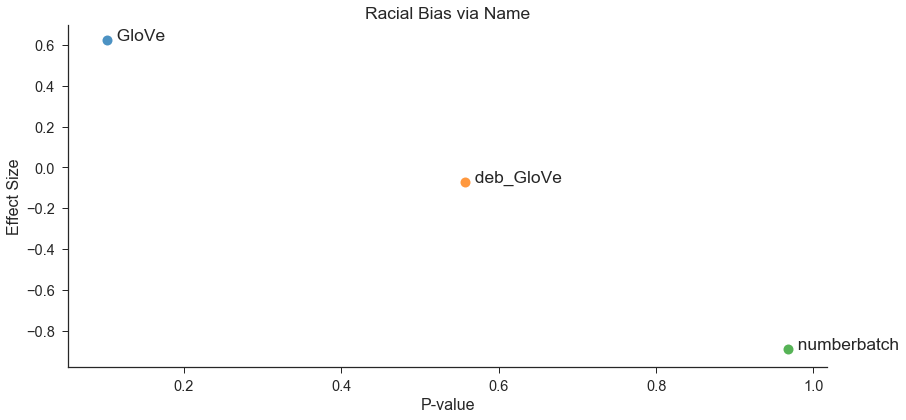

In [193]:
# plot of 9-name subset, all embeddings
plot_test(racial[racial.embedding != 'deb_GNews'], 'Racial Bias via Name')

### Re-test omitting the Bolukbasi debiased GoogleNews embedding

It has too small a vocabulary and is holding back a more comprehensive test of the others

In [194]:
shared_eu_amer_names = g_eu.intersection(n_eu)
shared_afr_amer_names = g_afr.intersection(n_afr)

len(shared_eu_amer_names), len(shared_afr_amer_names)

(48, 29)

In [195]:
afr_subset = shared_afr_amer_names
eu_subset = list(shared_eu_amer_names)
random.shuffle(eu_subset)
eu_subset  = set(eu_subset[:len(shared_afr_amer_names)])
eu_subset, afr_subset

({'adam',
  'amanda',
  'amber',
  'betsy',
  'colleen',
  'courtney',
  'crystal',
  'donna',
  'ellen',
  'emily',
  'frank',
  'harry',
  'ian',
  'jack',
  'jed',
  'katie',
  'lauren',
  'matthew',
  'nancy',
  'paul',
  'peggy',
  'ryan',
  'sara',
  'shannon',
  'stephanie',
  'stephen',
  'todd',
  'wendy',
  'wilbur'},
 {'alonzo',
  'alphonse',
  'darnell',
  'deion',
  'ebony',
  'jamel',
  'jasmine',
  'jerome',
  'lamar',
  'lamont',
  'latonya',
  'latoya',
  'lavon',
  'leroy',
  'lionel',
  'malik',
  'malika',
  'marcellus',
  'nichelle',
  'shaniqua',
  'tanisha',
  'terrence',
  'theo',
  'tia',
  'torrance',
  'tyrone',
  'wardell',
  'yolanda',
  'yvette'})

In [196]:
X_eu_amer_names = set(eu_subset)
Y_af_amer_names = set(afr_subset)
int(comb(len(X_eu_amer_names)*2, len(X_eu_amer_names)))

78861995

In [197]:
%%time
racial = []

e, p = weat.perform_test(X_eu_amer_names, Y_af_amer_names,
                         attr_pleasant, attr_unpleasant, max_iters=50000
                        )
racial.append({'effect_size':e, 'p_val':p, 'embedding':'GloVe'})

e, p = deb_weat.perform_test(X_eu_amer_names, Y_af_amer_names, 
                             attr_pleasant, attr_unpleasant, max_iters=50000
                            )
racial.append({'effect_size':e, 'p_val':p, 'embedding':'deb_GloVe'})

e, p = nbb_weat.perform_test(X_eu_amer_names, Y_af_amer_names, 
                             attr_pleasant, attr_unpleasant, max_iters=50000
                            )
racial.append({'effect_size':e, 'p_val':p, 'embedding':'numberbatch'})


# subset of 29 names from each target group for both GloVe and Numberbatch embeddings
racial = pd.DataFrame(racial)







CPU times: user 51.5 s, sys: 408 ms, total: 51.9 s
Wall time: 52.4 s


In [198]:
# 50k random iterations, 29 names each race
racial

,effect_size,embedding,p_val
0,1.135273,GloVe,0.00000
1,0.416921,deb_GloVe,0.05686
2,0.147859,numberbatch,0.29398


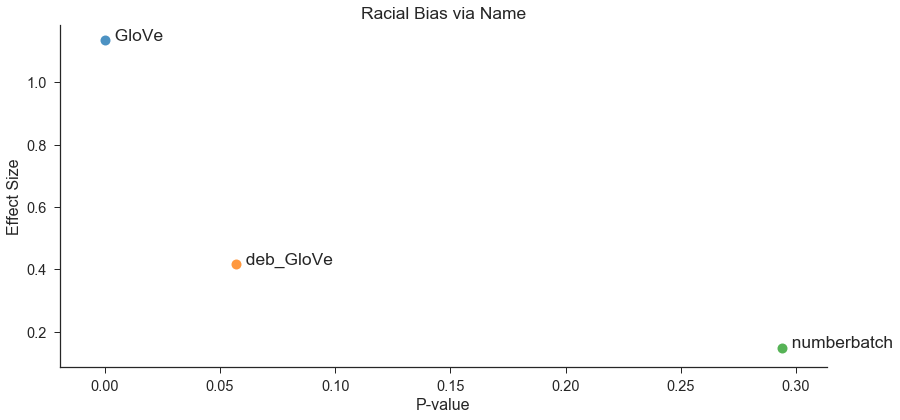

In [199]:
# plot of X names common to just GloVe and Numberbatch
plot_test(racial[racial.embedding != 'deb_GNews'], 'Racial Bias via Name')

### Try again with the 29 names and more iterations

In [200]:
%%time
racial = []

e, p = weat.perform_test(X_eu_amer_names, Y_af_amer_names,
                         attr_pleasant, attr_unpleasant, max_iters=150000
                        )
racial.append({'effect_size':e, 'p_val':p, 'embedding':'GloVe'})

e, p = deb_weat.perform_test(X_eu_amer_names, Y_af_amer_names, 
                             attr_pleasant, attr_unpleasant, max_iters=150000
                            )
racial.append({'effect_size':e, 'p_val':p, 'embedding':'deb_GloVe'})

e, p = nbb_weat.perform_test(X_eu_amer_names, Y_af_amer_names, 
                             attr_pleasant, attr_unpleasant, max_iters=150000
                            )
racial.append({'effect_size':e, 'p_val':p, 'embedding':'numberbatch'})


# subset of 29 names from each target group for both GloVe and Numberbatch embeddings
racial = pd.DataFrame(racial)










CPU times: user 2min 51s, sys: 1.85 s, total: 2min 53s
Wall time: 2min 54s


In [201]:
# 150k random iterations, 29 names each race
racial

,effect_size,embedding,p_val
0,1.135273,GloVe,0.000000
1,0.416921,deb_GloVe,0.058433
2,0.147859,numberbatch,0.291860


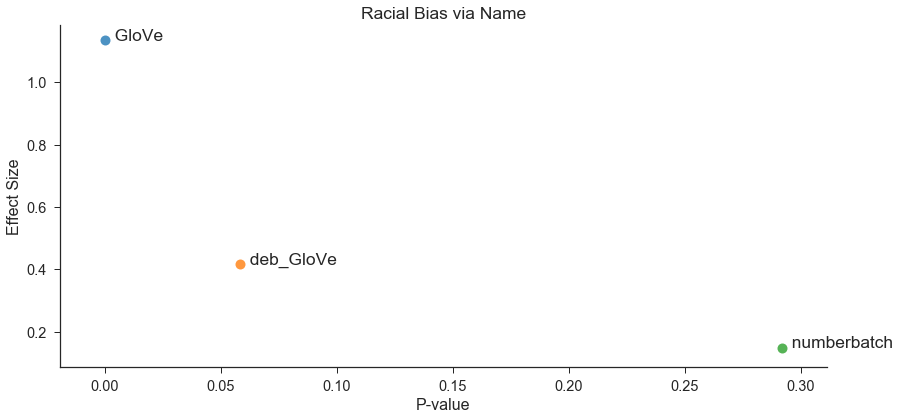

In [202]:
# plot of X names common to just GloVe and Numberbatch
plot_test(racial[racial.embedding != 'deb_GNews'], 'Racial Bias via Name')

## Investigate Fast Ways to Sample from the Partition Space in a Random Way

In [98]:
from itertools import combinations
from random import shuffle, sample
from math import floor

In [54]:
from scipy.misc import comb
ncombs = int(comb(64, 32))
ncombs

1832624140942590464

In [151]:
t_list = [5,4,3,2,1]
for i, _ in enumerate(range(len(t_list))):
    t = t_list.pop()
    t_list = [t] + t_list
    print(t_list)
    if i % len(t_list) == 0:
        # shuffle in a different way?

[1, 5, 4, 3, 2]
[2, 1, 5, 4, 3]
[3, 2, 1, 5, 4]
[4, 3, 2, 1, 5]
[5, 4, 3, 2, 1]


### OR just shuffle t_list and split in half every time and compare to seen

In [141]:
t_list = [5,4,3,2,1]
max_iters = 8
# shuffle the targets list after every 100 so we get a more diverse sample of partitions

for _ in range(floor(max_iters / 2)):
    for i, c in enumerate(combinations(t_list, 3)):
        if i == 2:
            # shuffle list
            shuffle(t_list)
            break
        print(c) 

(5, 4, 3)
(5, 4, 2)
(5, 3, 1)
(5, 3, 2)
(3, 4, 1)
(3, 4, 5)
(2, 3, 5)
(2, 3, 1)
